<ipython-input-21-356f0b160c09>:46: RuntimeWarning: invalid value encountered in divide
  t_stats = params / standard_errors
<ipython-input-21-356f0b160c09>:46: RuntimeWarning: invalid value encountered in divide
  t_stats = params / standard_errors
<ipython-input-21-356f0b160c09>:46: RuntimeWarning: invalid value encountered in divide
  t_stats = params / standard_errors
<ipython-input-21-356f0b160c09>:46: RuntimeWarning: invalid value encountered in divide
  t_stats = params / standard_errors
<ipython-input-21-356f0b160c09>:46: RuntimeWarning: invalid value encountered in divide
  t_stats = params / standard_errors
<ipython-input-21-356f0b160c09>:46: RuntimeWarning: invalid value encountered in divide
  t_stats = params / standard_errors


              Buyuk      Uzun  Genis(burun_deligi)   Kemerli    Uzun.1  \
accuracy   0.677419  0.645161             0.645161  0.677419  0.709677   
precision  0.833333  0.571429             0.714286  0.687500  0.800000   
recall     0.555556  0.333333             0.750000  0.687500  0.533333   
f1_score   0.666667  0.421053             0.731707  0.687500  0.640000   

           Genislik  
accuracy   0.483871  
precision  0.523810  
recall     0.647059  
f1_score   0.578947  


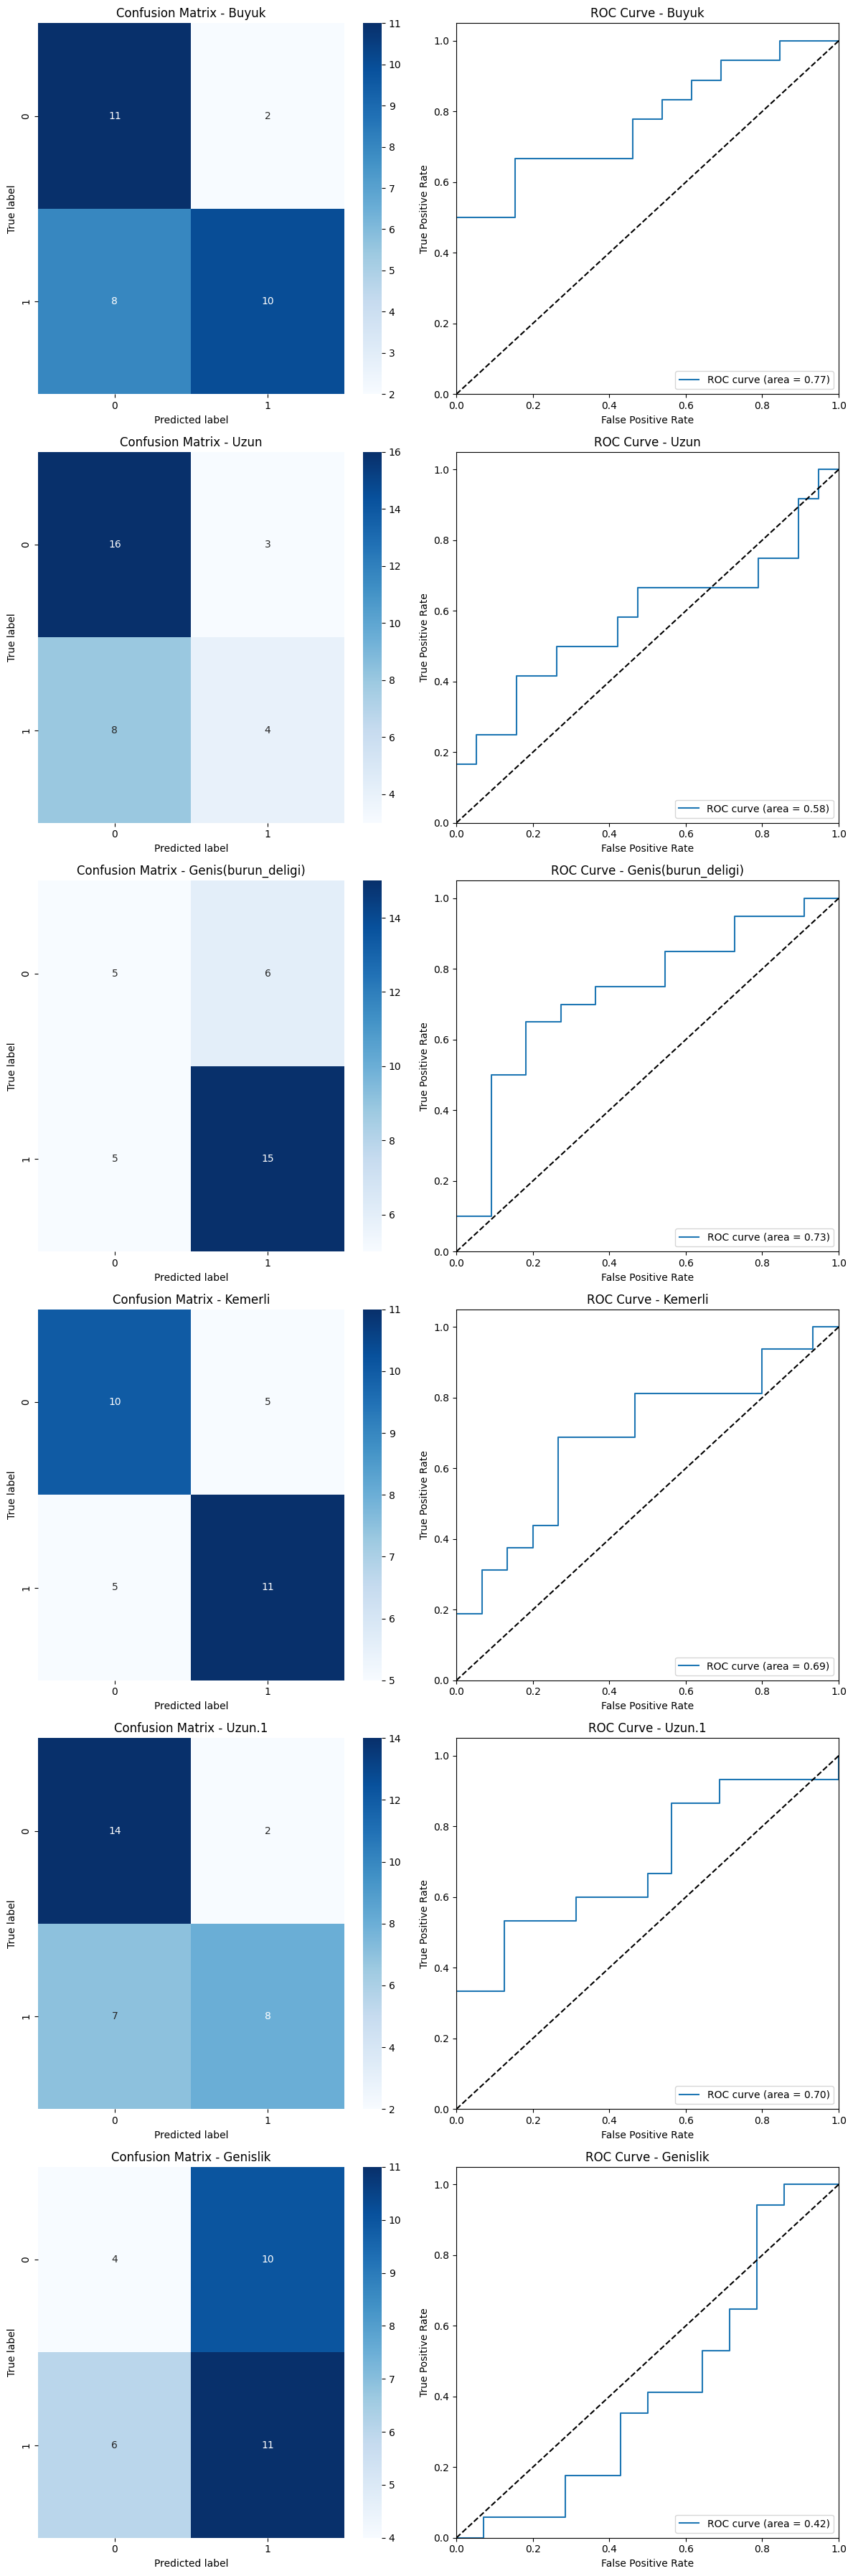

Feature coefficients and p-values have been saved to separate Excel files.


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Load the dataset
file_path = '/content/Burun_tahmin.xlsx'
data = pd.read_excel(file_path)
data.head()

# Extracting features and target variables
features = data.iloc[:, :-6]
targets = data.iloc[:, -6:]

# Convert DNA features to numeric using one-hot encoding
features_encoded = pd.get_dummies(features, drop_first=True)

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["feature"] = features_encoded.columns
vif_data["VIF"] = [variance_inflation_factor(features_encoded.values, i) for i in range(len(features_encoded.columns))]

# Identify features with VIF > 10 and remove them
high_vif_features = vif_data[vif_data["VIF"] > 10]["feature"].tolist()
features_reduced = features_encoded.drop(columns=high_vif_features)

# Function to calculate p-values using standard errors
def calculate_p_values_sklearn(model, X):
    params = np.append(model.intercept_, model.coef_)
    predictions = model.predict_proba(X)

    # Construct matrix of feature values
    X_design = np.hstack([np.ones((X.shape[0], 1)), X])

    # Calculate the covariance matrix
    V = np.cov(X_design.T)

    # Calculate the standard errors
    standard_errors = np.sqrt(np.diag(np.dot(np.dot(X_design.T, np.diag(predictions[:, 1] * (1 - predictions[:, 1]))), X_design)))

    # Calculate the t-statistics
    t_stats = params / standard_errors

    # Calculate the p-values
    p_values = [2 * (1 - norm.cdf(np.abs(t))) for t in t_stats]

    return p_values

# Initialize a dictionary to store the results
results = {}
p_values_dict_reduced = {}
output_dir = '/content/coefficients/'

# Iterate over each target and train a logistic regression model
for target in targets.columns:
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(features_reduced, targets[target], test_size=0.3, random_state=42)

    # Initialize and train the logistic regression model
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1]

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Calculate ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    # Store the results
    results[target] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'confusion_matrix': conf_matrix,
        'roc_curve': (fpr, tpr, roc_auc)
    }

    # Calculate p-values
    p_values = calculate_p_values_sklearn(model, X_train)
    p_values_dict_reduced[target] = p_values

    # Get the feature coefficients
    coefficients = pd.DataFrame({'Feature': ['Intercept'] + features_reduced.columns.tolist(), 'Coefficient': np.append(model.intercept_, model.coef_[0])})

    # Save the coefficients to an Excel file
    coefficients.to_excel(f'{output_dir}{target}_coefficients.xlsx', index=False)

# Display results in a DataFrame
results_df = pd.DataFrame({k: {metric: v[metric] for metric in v if metric != 'confusion_matrix' and metric != 'roc_curve'} for k, v in results.items()})
print(results_df)

# Plot confusion matrices and ROC curves
fig, axs = plt.subplots(len(targets.columns), 2, figsize=(12, len(targets.columns)*6))

for idx, target in enumerate(targets.columns):
    # Confusion matrix
    conf_matrix = results[target]['confusion_matrix']
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=axs[idx, 0])
    axs[idx, 0].set_title(f'Confusion Matrix - {target}')
    axs[idx, 0].set_xlabel('Predicted label')
    axs[idx, 0].set_ylabel('True label')

    # ROC curve
    fpr, tpr, roc_auc = results[target]['roc_curve']
    axs[idx, 1].plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:0.2f})')
    axs[idx, 1].plot([0, 1], [0, 1], 'k--')
    axs[idx, 1].set_xlim([0.0, 1.0])
    axs[idx, 1].set_ylim([0.0, 1.05])
    axs[idx, 1].set_xlabel('False Positive Rate')
    axs[idx, 1].set_ylabel('True Positive Rate')
    axs[idx, 1].set_title(f'ROC Curve - {target}')
    axs[idx, 1].legend(loc="lower right")

plt.tight_layout()
plt.show()

# Convert p-values to a DataFrame
p_values_df_reduced = pd.DataFrame(p_values_dict_reduced, index=['Intercept'] + features_reduced.columns.tolist())
p_values_df_reduced.to_excel('/content/data/p_values_reduced.xlsx')

print("Feature coefficients and p-values have been saved to separate Excel files.")


              Buyuk      Uzun  Genis(burun_deligi)   Kemerli    Uzun.1  \
accuracy   0.806452  0.580645             0.645161  0.741935  0.645161   
precision  0.928571  0.428571             0.714286  0.722222  0.750000   
recall     0.722222  0.250000             0.750000  0.812500  0.400000   
f1_score   0.812500  0.315789             0.731707  0.764706  0.521739   

           Genislik  
accuracy   0.548387  
precision  0.571429  
recall     0.705882  
f1_score   0.631579  


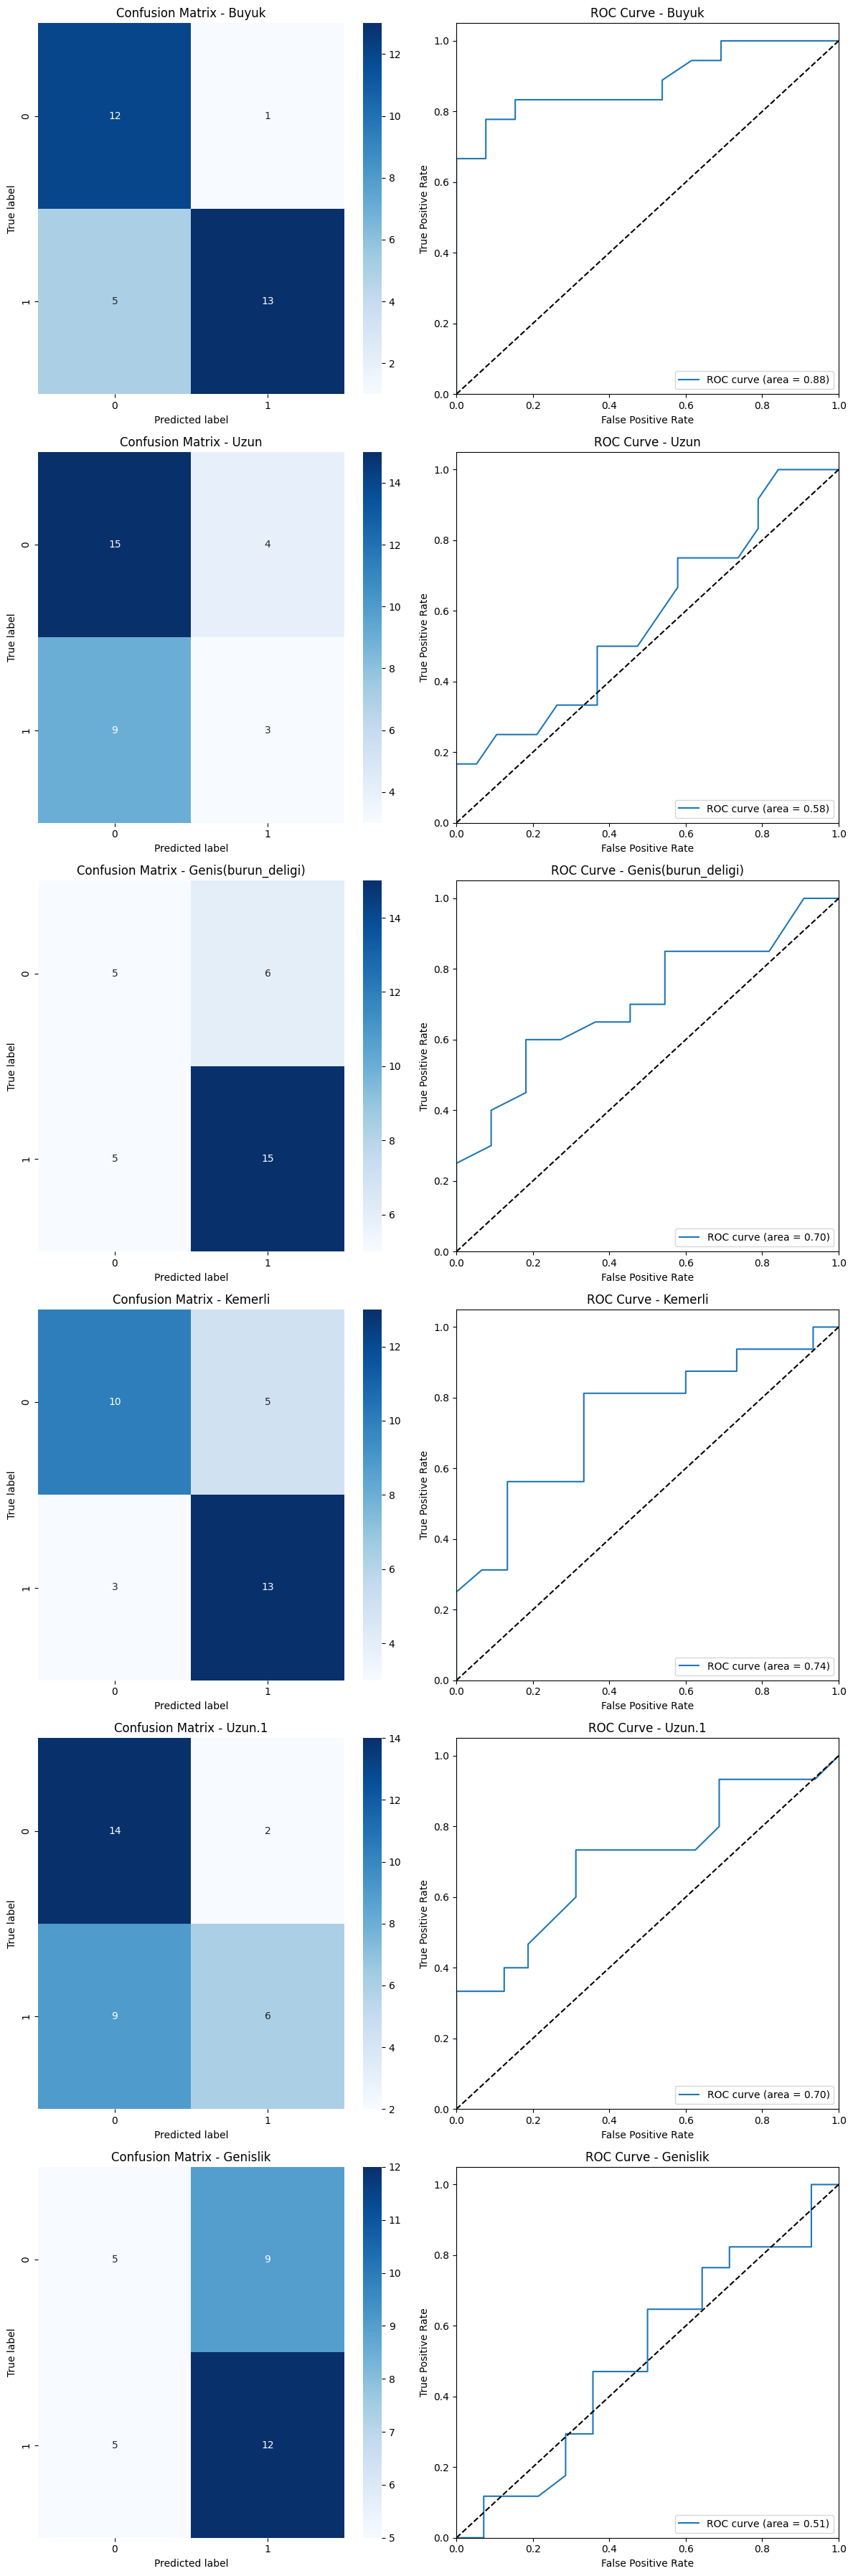

In [ ]:
# Load the dataset
file_path = '/content/Burun_tahmin.xlsx'
data = pd.read_excel(file_path)
data.head()

# Extracting features and target variables
features = data.iloc[:, :-6]
targets = data.iloc[:, -6:]

# Convert DNA features to numeric using one-hot encoding
features_encoded = pd.get_dummies(features, drop_first=True)

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["feature"] = features_encoded.columns
vif_data["VIF"] = [variance_inflation_factor(features_encoded.values, i) for i in range(len(features_encoded.columns))]

# Identify features with VIF > 10 and remove them
high_vif_features = vif_data[vif_data["VIF"] > 10]["feature"].tolist()
features_reduced = features_encoded.drop(columns=high_vif_features)

# Initialize a dictionary to store the results
results = {}

# Iterate over each target and train a Random Forest classifier
for target in targets.columns:
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(features_reduced, targets[target], test_size=0.3, random_state=42)

    # Initialize and train the Random Forest classifier
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1]

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Calculate ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    # Store the results
    results[target] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'confusion_matrix': conf_matrix,
        'roc_curve': (fpr, tpr, roc_auc)
    }

# Display results in a DataFrame
results_df = pd.DataFrame({k: {metric: v[metric] for metric in v if metric != 'confusion_matrix' and metric != 'roc_curve'} for k, v in results.items()})
print(results_df)

# Plot confusion matrices and ROC curves
fig, axs = plt.subplots(len(targets.columns), 2, figsize=(12, len(targets.columns)*6))

for idx, target in enumerate(targets.columns):
    # Confusion matrix
    conf_matrix = results[target]['confusion_matrix']
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=axs[idx, 0])
    axs[idx, 0].set_title(f'Confusion Matrix - {target}')
    axs[idx, 0].set_xlabel('Predicted label')
    axs[idx, 0].set_ylabel('True label')

    # ROC curve
    fpr, tpr, roc_auc = results[target]['roc_curve']
    axs[idx, 1].plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:0.2f})')
    axs[idx, 1].plot([0, 1], [0, 1], 'k--')
    axs[idx, 1].set_xlim([0.0, 1.0])
    axs[idx, 1].set_ylim([0.0, 1.05])
    axs[idx, 1].set_xlabel('False Positive Rate')
    axs[idx, 1].set_ylabel('True Positive Rate')
    axs[idx, 1].set_title(f'ROC Curve - {target}')
    axs[idx, 1].legend(loc="lower right")

plt.tight_layout()
plt.show()


Results for Naive Bayes:
               Buyuk      Uzun  Genis(burun_deligi)   Kemerli    Uzun.1  \
accuracy   0.483871  0.322581             0.709677  0.548387  0.548387   
precision  0.750000  0.304348             0.923077  0.666667  0.666667   
recall     0.166667  0.583333             0.600000  0.250000  0.133333   
f1_score   0.272727  0.400000             0.727273  0.363636  0.222222   

           Genislik  
accuracy   0.516129  
precision  0.625000  
recall     0.294118  
f1_score   0.400000   

Results for Decision Tree:
               Buyuk      Uzun  Genis(burun_deligi)   Kemerli    Uzun.1  \
accuracy   0.741935  0.483871             0.870968  0.709677  0.645161   
precision  0.857143  0.250000             0.900000  0.769231  0.700000   
recall     0.666667  0.166667             0.900000  0.625000  0.466667   
f1_score   0.750000  0.200000             0.900000  0.689655  0.560000   

           Genislik  
accuracy   0.451613  
precision  0.500000  
recall     0.647059  
f1_s

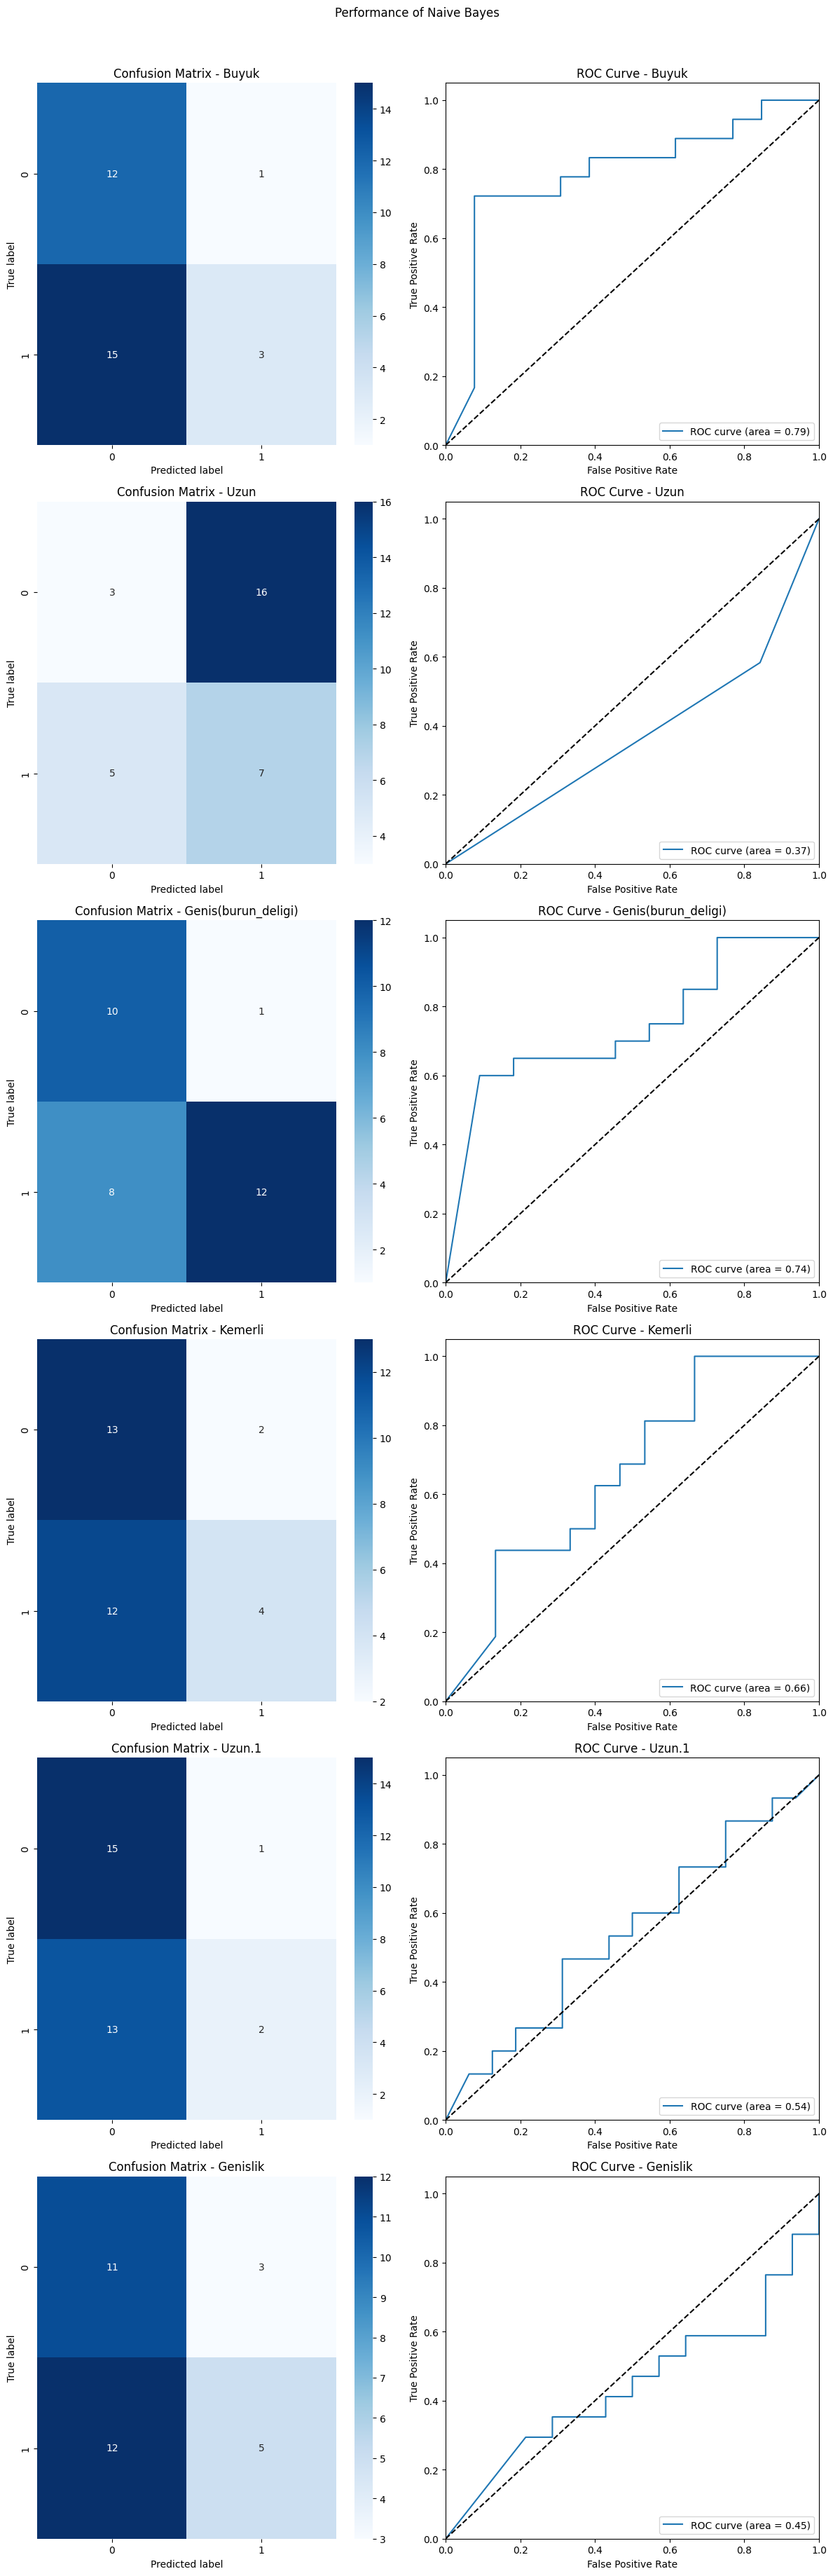

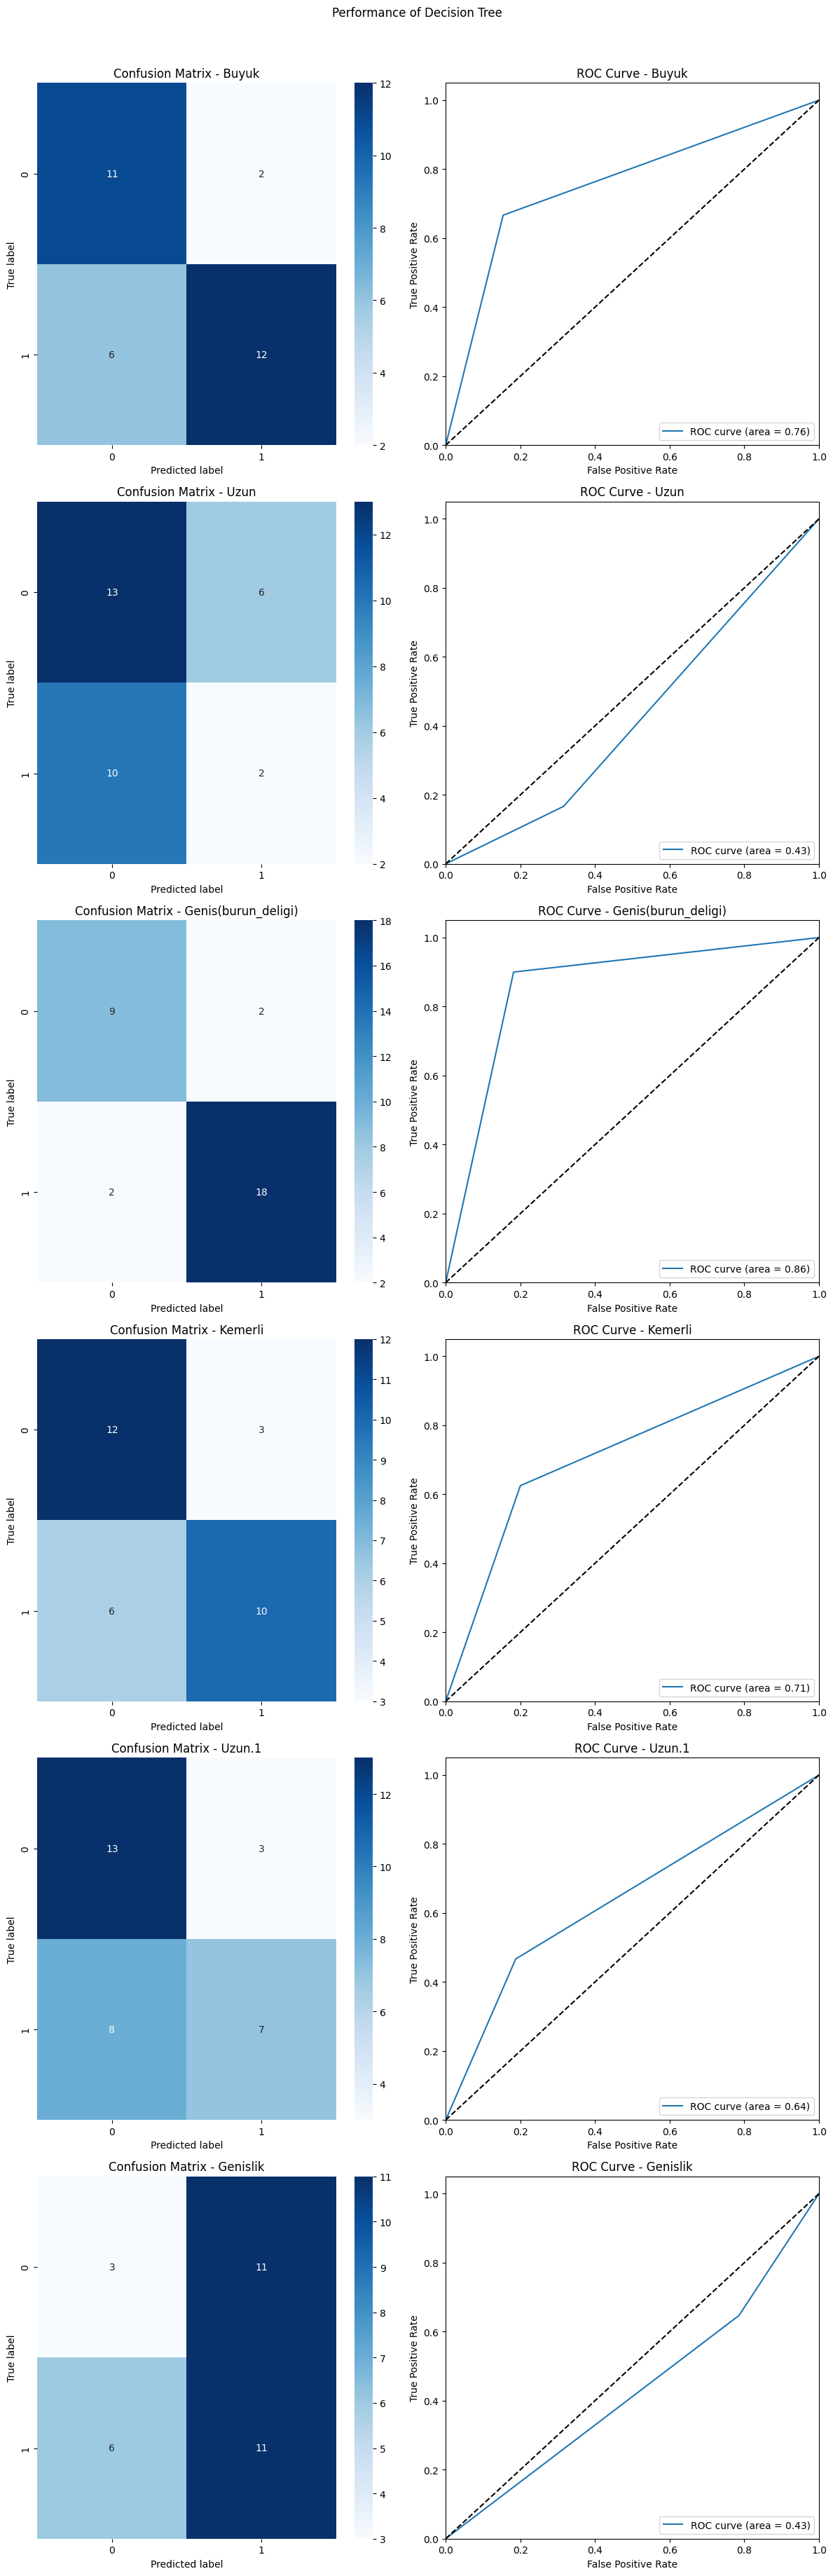

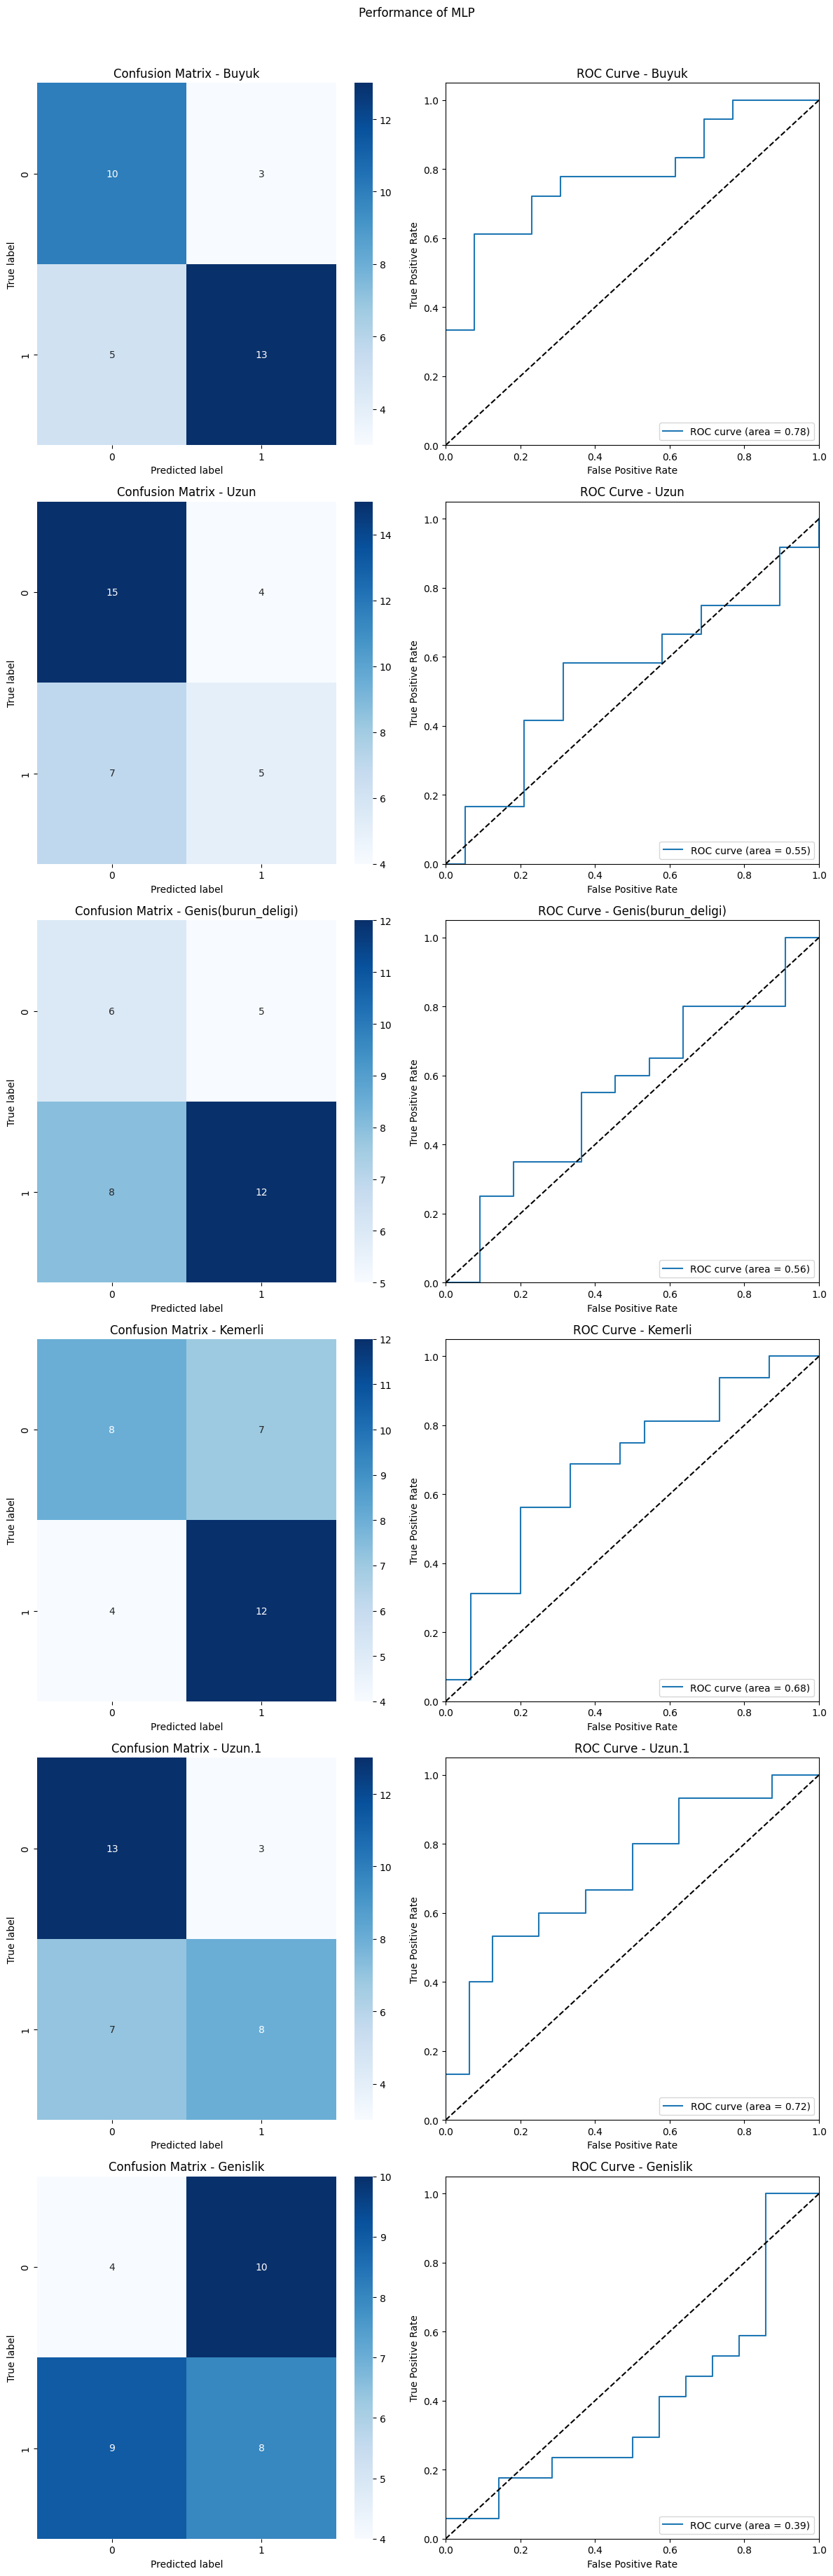

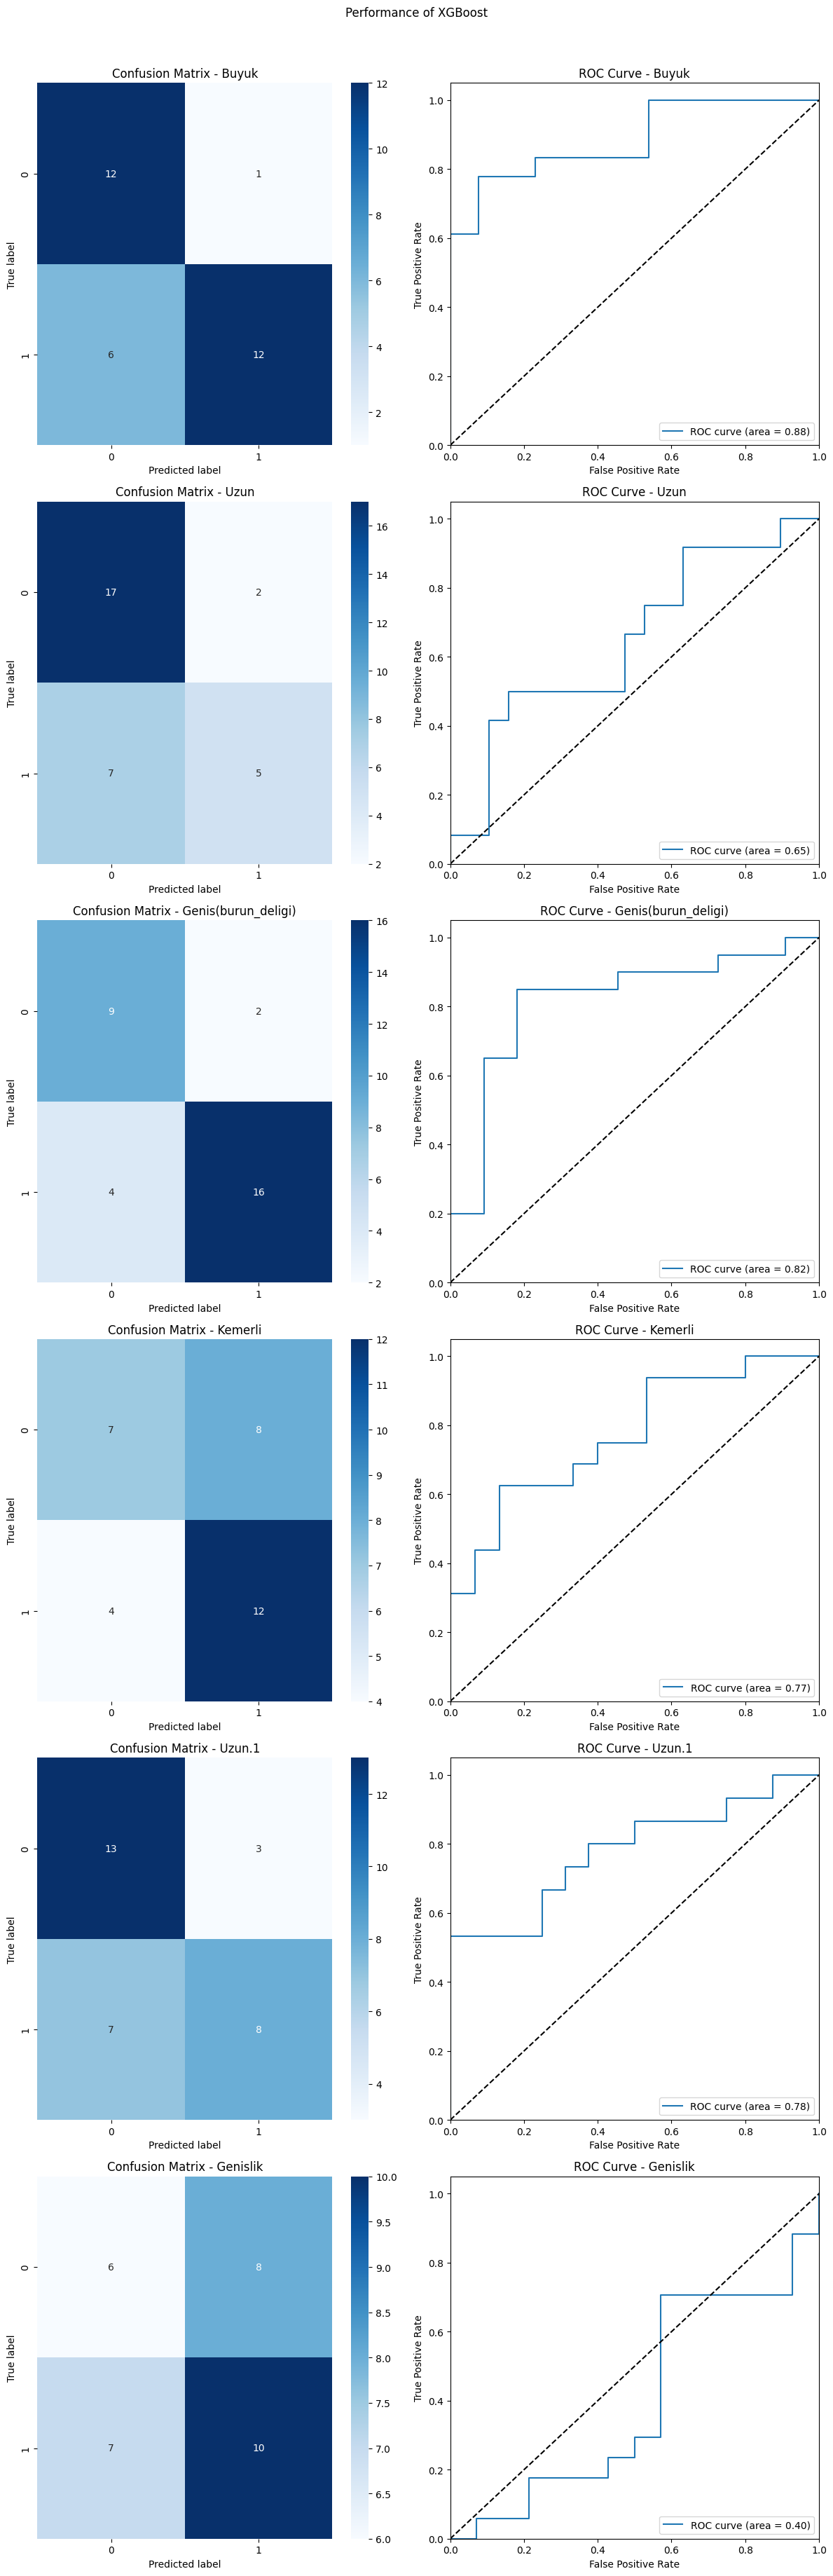

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Load the dataset
file_path = '/content/Burun_tahmin.xlsx'
data = pd.read_excel(file_path)
data.head()

# Extracting features and target variables
features = data.iloc[:, :-6]
targets = data.iloc[:, -6:]

# Convert DNA features to numeric using one-hot encoding
features_encoded = pd.get_dummies(features, drop_first=True)

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["feature"] = features_encoded.columns
vif_data["VIF"] = [variance_inflation_factor(features_encoded.values, i) for i in range(len(features_encoded.columns))]

# Identify features with VIF > 10 and remove them
high_vif_features = vif_data[vif_data["VIF"] > 10]["feature"].tolist()
features_reduced = features_encoded.drop(columns=high_vif_features)

# Define classifiers
classifiers = {
    "Naive Bayes": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "MLP": MLPClassifier(max_iter=1000, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# Initialize a dictionary to store the results
results = {clf_name: {} for clf_name in classifiers}

# Iterate over each target and classifier, train the models, and evaluate them
for clf_name, clf in classifiers.items():
    for target in targets.columns:
        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(features_reduced, targets[target], test_size=0.3, random_state=42)

        # Initialize and train the classifier
        clf.fit(X_train, y_train)

        # Make predictions
        y_pred = clf.predict(X_test)
        y_pred_prob = clf.predict_proba(X_test)[:, 1]

        # Evaluate the model
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        # Calculate confusion matrix
        conf_matrix = confusion_matrix(y_test, y_pred)

        # Calculate ROC curve and AUC
        fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
        roc_auc = auc(fpr, tpr)

        # Store the results
        results[clf_name][target] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'confusion_matrix': conf_matrix,
            'roc_curve': (fpr, tpr, roc_auc)
        }

# Display results in a DataFrame for each classifier
for clf_name in classifiers:
    results_df = pd.DataFrame({k: {metric: v[metric] for metric in v if metric != 'confusion_matrix' and metric != 'roc_curve'} for k, v in results[clf_name].items()})
    print(f"Results for {clf_name}:\n", results_df, "\n")

# Plot confusion matrices and ROC curves for each classifier
for clf_name in classifiers:
    fig, axs = plt.subplots(len(targets.columns), 2, figsize=(12, len(targets.columns)*6))

    for idx, target in enumerate(targets.columns):
        # Confusion matrix
        conf_matrix = results[clf_name][target]['confusion_matrix']
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=axs[idx, 0])
        axs[idx, 0].set_title(f'Confusion Matrix - {target}')
        axs[idx, 0].set_xlabel('Predicted label')
        axs[idx, 0].set_ylabel('True label')

        # ROC curve
        fpr, tpr, roc_auc = results[clf_name][target]['roc_curve']
        axs[idx, 1].plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:0.2f})')
        axs[idx, 1].plot([0, 1], [0, 1], 'k--')
        axs[idx, 1].set_xlim([0.0, 1.0])
        axs[idx, 1].set_ylim([0.0, 1.05])
        axs[idx, 1].set_xlabel('False Positive Rate')
        axs[idx, 1].set_ylabel('True Positive Rate')
        axs[idx, 1].set_title(f'ROC Curve - {target}')
        axs[idx, 1].legend(loc="lower right")

    plt.tight_layout()
    plt.suptitle(f'Performance of {clf_name}', y=1.02)
    plt.show()
